<a href="https://colab.research.google.com/github/sameer1604/Cifar10/blob/main/Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [ ]:
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from tensorflow.keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical


# Getting the Dataset & splitting it

In [ ]:
(X_train, y_train), (X_test, y_test)=keras.datasets.cifar10.load_data()

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=.3)

In [ ]:
print((X_train.shape,y_train.shape))
print((X_val.shape,y_val.shape))
print((X_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [ ]:
y_train=y_train.flatten()
y_val=y_val.flatten()
y_test=y_test.flatten()

# Distribution of data in classes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[Text(0, 0, 'airplane'),
  Text(0, 0, 'automobile'),
  Text(0, 0, 'bird'),
  Text(0, 0, 'cat'),
  Text(0, 0, 'deer'),
  Text(0, 0, 'dog'),
  Text(0, 0, 'frog'),
  Text(0, 0, 'horse'),
  Text(0, 0, 'ship'),
  Text(0, 0, 'truck')]]

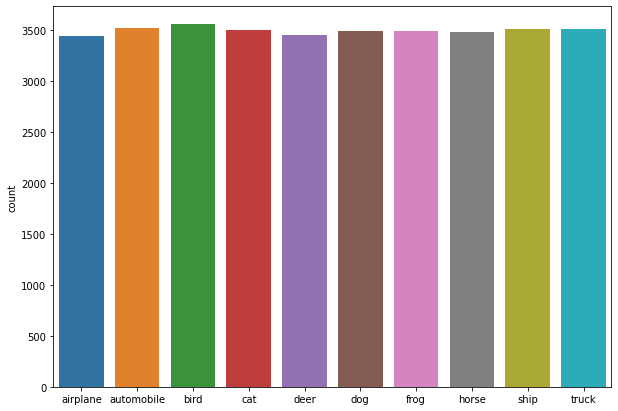

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes)

# Data Normalization & Augmentation

In [ ]:
input_shape = (32, 32, 3)

X_train=X_train / 255.0
X_val=X_val / 255.0
X_test=X_test / 255.0

In [ ]:
X_train.shape

(35000, 32, 32, 3)

In [ ]:
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [ ]:
train_generator.fit(X_train)
val_generator.fit(X_val)
test_generator.fit(X_test)

# Hot encoding the labels to categorical

In [ ]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
y_val= tf.one_hot(y_val.astype(np.int32), depth=10)

In [ ]:
y_train

<tf.Tensor: shape=(35000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

# Plotting the images
Below the image is shown of an airplane.

tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


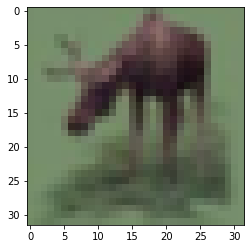

In [ ]:
plt.imshow(X_train[55])
print(y_train[55])

## Importing the VGG19 model
We'll be using the VGG19 model pretrained on ImageNet dataset.

In [ ]:
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

80142336/80134624 [==============================] - 0s 0us/step


# Adding extra layers to it and compiling the model

In [ ]:
model_1= Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten())
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dropout(0.3))
model_1.add(Dense(256,activation=('relu'))) 
model_1.add(Dropout(0.3))
model_1.add(Dense(128,activation=('relu')))
model_1.add(Dropout(0.3))
model_1.add(Dense(10,activation=('softmax')))
learn_rate=.001

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
lrr= ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5)

# Training VGG19 on the CIFAR-10 dataset

In [ ]:
batch_size=200
try3=model_1.fit(train_generator.flow(X_train,y_train,batch_size=batch_size),
                      epochs=10,
                      steps_per_epoch=X_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(X_val,y_val,batch_size=batch_size),validation_steps=X_val.shape[0]//batch_size,callbacks=[lrr],
                      verbose=1)


Epoch 1/10
175/175 [==============================] - 50s 165ms/step - loss: 2.1743 - accuracy: 0.1845 - val_loss: 1.3172 - val_accuracy: 0.5325
Epoch 2/10
175/175 [==============================] - 26s 150ms/step - loss: 1.3634 - accuracy: 0.5223 - val_loss: 0.9586 - val_accuracy: 0.6747
Epoch 3/10
175/175 [==============================] - 27s 156ms/step - loss: 1.0615 - accuracy: 0.6510 - val_loss: 0.8109 - val_accuracy: 0.7306
Epoch 4/10
175/175 [==============================] - 27s 154ms/step - loss: 0.9379 - accuracy: 0.6966 - val_loss: 0.7888 - val_accuracy: 0.7325
Epoch 5/10
175/175 [==============================] - 26s 150ms/step - loss: 0.8407 - accuracy: 0.7273 - val_loss: 0.7129 - val_accuracy: 0.7585
Epoch 6/10
175/175 [==============================] - 26s 151ms/step - loss: 0.7568 - accuracy: 0.7575 - val_loss: 0.7096 - val_accuracy: 0.7692
Epoch 7/10
175/175 [==============================] - 26s 151ms/step - loss: 0.7205 - accuracy: 0.7683 - val_loss: 0.6598 - val_ac

# Plotting the loss and accuracy graphs for training and validation

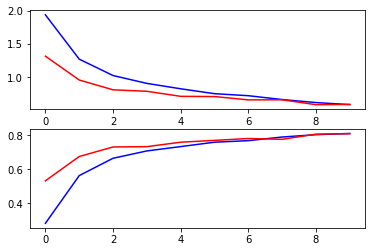

In [ ]:
#Plot the training and valiation loss
'''The output of model.fit is a model.History object which is a record of metrics at each epoch. This can be used to graph the training and validation accuracy
to see where they plateaued off and if overfitting can subsequently be avoided'''

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model_1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_1.history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(model_1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model_1.history.history['val_accuracy'],color='r',label='Validation Accuracy')

# Defining the function for the confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

    np.set_printoptions(precision=2)

# Using the trained VGG19 model to make a prediction on the test set

In [ ]:
y_pred=model_1.predict_classes(X_test)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Confusion Matrix for VGG19 

Confusion matrix, without normalization


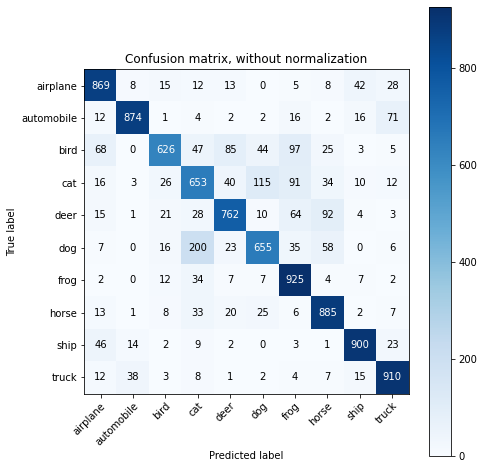

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=classes,title='Confusion matrix, without normalization')

# Developing another custom CNN and compiling it

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=X_train.shape[1:], activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-06),
            loss='categorical_crossentropy', metrics=['accuracy'])

# Training the custom CNN model on the data

In [ ]:
batch_size=100
try3=model.fit(train_generator.flow(X_train,y_train,batch_size=batch_size),
                      epochs=50,
                      steps_per_epoch=X_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(X_val,y_val,batch_size=batch_size),validation_steps=X_val.shape[0]//batch_size,callbacks=[lrr],
                      verbose=1)

Epoch 1/50
350/350 [==============================] - 52s 59ms/step - loss: 1.8160 - accuracy: 0.3453 - val_loss: 1.4707 - val_accuracy: 0.4733
Epoch 2/50
350/350 [==============================] - 20s 57ms/step - loss: 1.4226 - accuracy: 0.4928 - val_loss: 1.3890 - val_accuracy: 0.5079
Epoch 3/50
350/350 [==============================] - 20s 58ms/step - loss: 1.2517 - accuracy: 0.5576 - val_loss: 1.3103 - val_accuracy: 0.5453
Epoch 4/50
350/350 [==============================] - 21s 60ms/step - loss: 1.1272 - accuracy: 0.6057 - val_loss: 1.0538 - val_accuracy: 0.6334
Epoch 5/50
350/350 [==============================] - 20s 57ms/step - loss: 1.0365 - accuracy: 0.6353 - val_loss: 1.0040 - val_accuracy: 0.6455
Epoch 6/50
350/350 [==============================] - 20s 57ms/step - loss: 0.9785 - accuracy: 0.6567 - val_loss: 0.9814 - val_accuracy: 0.6629
Epoch 7/50
350/350 [==============================] - 21s 61ms/step - loss: 0.9259 - accuracy: 0.6788 - val_loss: 0.9120 - val_accuracy:

# Plotting loss and accuracy

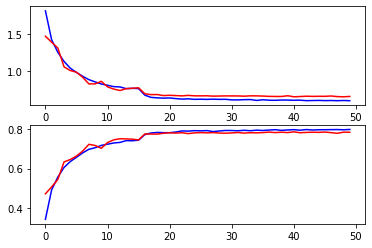

In [ ]:
#Plot the training and valiation loss
'''The output of model.fit is a model.History object which is a record of metrics at each epoch. This can be used to graph the training and validation accuracy
to see where they plateaued off and if overfitting can subsequently be avoided'''

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

# Using the custom model to make a prediction on the test set

In [ ]:
y_pred=model.predict(X_test)
y_true=np.argmax(y_test,axis=1)
model.evaluate(X_test,y_test)
y_pred[0]
#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

KeyboardInterrupt: ignored

# Confusion Matrix for Custon CNN

Confusion matrix, without normalization


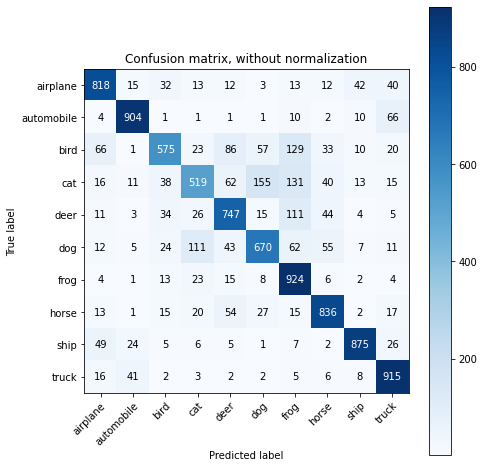

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=classes,title='Confusion matrix, without normalization')

# Preprocessing the dataset for ResNet50

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [ ]:
train_X = preprocess_image_input(X_train)
valid_X = preprocess_image_input(X_val)
y_train = tf.argmax(y_train, axis=1)
y_test = tf.argmax(y_test, axis=1)
y_val = tf.argmax(y_val, axis=1)
y_train.shape
y_test.shape
y_val.shape

TensorShape([15000])

# Importing and defining ResNet50 and compiling the model

In [ ]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800

# Training the ResNet50 model

In [ ]:
EPOCHS = 10
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_val, y_val), batch_size=64)

Epoch 1/10
547/547 [==============================] - 371s 663ms/step - loss: 0.5638 - accuracy: 0.8118 - val_loss: 2.8873 - val_accuracy: 0.1552
Epoch 2/10
547/547 [==============================] - 366s 669ms/step - loss: 0.1485 - accuracy: 0.9517 - val_loss: 0.3183 - val_accuracy: 0.8948
Epoch 3/10
547/547 [==============================] - 367s 670ms/step - loss: 0.0518 - accuracy: 0.9851 - val_loss: 0.2106 - val_accuracy: 0.9311
Epoch 4/10
547/547 [==============================] - 367s 670ms/step - loss: 0.0195 - accuracy: 0.9958 - val_loss: 0.2251 - val_accuracy: 0.9358
Epoch 5/10
547/547 [==============================] - 367s 670ms/step - loss: 0.0086 - accuracy: 0.9987 - val_loss: 0.2272 - val_accuracy: 0.9353
Epoch 6/10
547/547 [==============================] - 366s 670ms/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.2312 - val_accuracy: 0.9373
Epoch 7/10
547/547 [==============================] - 367s 670ms/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.2301 -

# Plotting the accuracy and loss curves

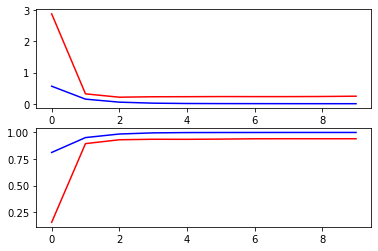

In [ ]:
#Plot the training and valiation loss
'''The output of model.fit is a model.History object which is a record of metrics at each epoch. This can be used to graph the training and validation accuracy
to see where they plateaued off and if overfitting can subsequently be avoided'''

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

# Predicting values using the trained model

In [ ]:
y_pred=model.predict(X_test)
y_true=y_test
model.evaluate(X_test,y_test)


313/313 [==============================] - 27s 87ms/step - loss: 0.2608 - accuracy: 0.9399


[0.26083052158355713, 0.9398999810218811]

In [ ]:
y_pred=np.argmax(y_pred,axis=1)
y_pred[0]
#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

# Plotting the confusion matrix for ResNet50

Confusion matrix, without normalization


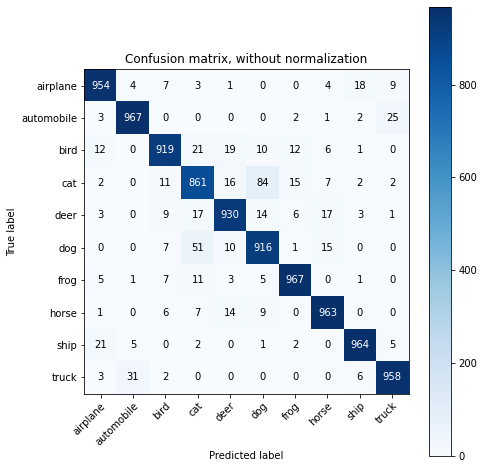

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=classes,title='Confusion matrix, without normalization')